# Fitting a model to data

A walkthrough of the exercises in the paper ['Data analysis recipes: fitting a model to data'](https://arxiv.org/abs/1008.4686).

In [101]:
import numpy as np
import scipy
from emcee import EnsembleSampler
from corner import corner
import matplotlib.pyplot as plt
%matplotlib inline

Initializing the data that we will use:

In [102]:

x = np.array([201, 244, 47, 287, 203, 58, 210, 202, 198, 158, 165, 201, 157, 131, 166, 160, 186, 125, 218, 146])
y = np.array([592, 401, 583, 402, 495, 173, 479, 504, 510, 416, 393, 442, 317, 311, 400, 337, 423, 334, 533, 344])
sigma_y = np.array([61, 25, 38, 15, 21, 15, 27, 14, 30, 16, 14, 25, 52, 16, 34, 31, 42, 26, 16, 22])
sigma_x = np.array([9, 4, 11, 7, 5, 9, 4, 4, 11, 7, 5, 5, 5, 6, 6, 5, 9, 8, 6, 5])
rho_xy = np.array([-0.84, 0.31, 0.64, -0.27, -0.33, 0.67, -0.02, -0.05, -0.84, -0.69, 0.3, -0.46, -0.03, 0.5, 0.73, -0.52, 0.9, 0.4, -0.78, -0.56])

## Exercise 1

*Using the standard linear algebra method of this Section, fit
the straight line $y = mx + b$ to the $x$, $y$, and $\sigma_y$ values for data points 5
through 20 in Table 1 on page 6. That is, ignore the first four data points,
and also ignore the columns for $\sigma_x$ and $\rho_{xy}$. Make a plot showing the points,
their uncertainties, and the best-fit line. Your plot should end up looking
like Figure 1. What is the standard uncertainty variance $\sigma^2_m$ on the slope of
the line?*

y = (2.24 +- 0.11)x + 34 +- 18


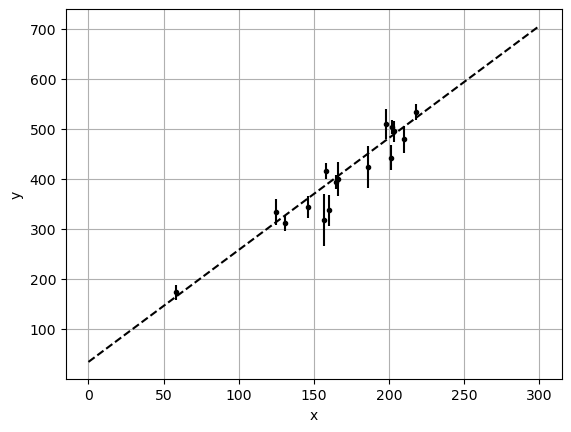

In [103]:
xlim = [0, 300]

def least_squares(x, y, sigma_y):
    A = np.vander(x, 2)
    inv_cov = np.diag(1 / sigma_y ** 2)
    A_reduced_dim = A.T @ inv_cov @ A
    param_cov = np.linalg.inv(A_reduced_dim)
    m, b = np.linalg.solve(A_reduced_dim, A.T @ inv_cov @ y)
    return m, b, np.sqrt(param_cov[0, 0]), np.sqrt(param_cov[1, 1])

m, b, sigma_m, sigma_b = least_squares(x[4:], y[4:], sigma_y[4:])

x_fit = np.linspace(*xlim, 1000)
y_fit = b + m * x_fit
print("y = ({:.2f} +- {:.2f})x + {:.0f} +- {:.0f}".format(m, sigma_m, b, sigma_b))
plt.errorbar(x[4:], y[4:], yerr=sigma_y[4:], fmt=".k")
plt.plot(x_fit, y_fit, ls='--', c='k')
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Exercise 2

*Repeat Exercise 1 but for all the data points in Table 1 on
page 6. Your plot should end up looking like Figure 2. What is the standard
uncertainty variance $\sigma^2_m$ on the slope of the line? Is there anything you don’t
like about the result? Is there anything different about the new points you
have included beyond those used in Exercise 1?*

y = (1.08 +- 0.08)x + 213 +- 14


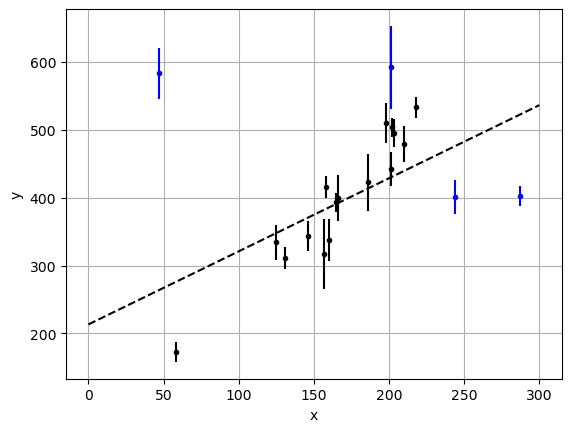

In [104]:
m, b, sigma_m, sigma_b = least_squares(x, y, sigma_y)
y_fit = b + m * x_fit
print("y = ({:.2f} +- {:.2f})x + {:.0f} +- {:.0f}".format(m, sigma_m, b, sigma_b))
plt.errorbar(x[:4], y[:4], yerr=sigma_y[:4], fmt=".b")
plt.errorbar(x[4:], y[4:], yerr=sigma_y[4:], fmt=".k")
plt.plot(x_fit, y_fit, ls='--', c='k')
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

The four extra points that were included in this exercise are represented in blue. They have a significant impact on the linear fit: the slope is reduced by more than half and the intercept is adjusted by $\sim 200$ to compensate. As a consequence, the fitted line does not seem to follow the trend in the data that is more clumped together in $x \in [125, 225]$. After a visual inspection, one is eager to classify these extra points as outliers. 

## Exercise 3

*Generalize the method of this Section to fit a general quadratic
(second order) relationship. Add another column to matrix $A$ containing the
values $x^2_i$, and another element to vector $\mathbf{X}$ (call it $q$). Then re-do Exercise 1
but fitting for and plotting the best quadratic relationship*
$$ g(x) = qx^2 + mx + b . $$ 
*Your plot should end up looking like Figure 3.*

y = (0.0023 +- 0.0020)x^2 + (1.60 +- 0.58)x + 73 +- 39


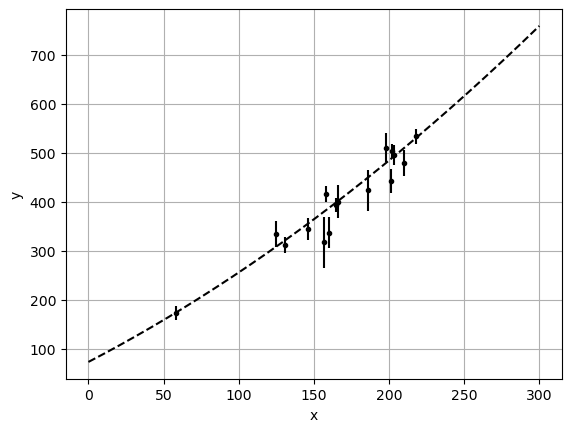

In [105]:
def n_dim_least_squares(x, y, sigma_y, n=2):
    A = np.vander(x, n)
    inv_cov = np.diag(1 / sigma_y ** 2)
    A_reduced_dim = A.T @ inv_cov @ A
    param_cov = np.linalg.inv(A_reduced_dim)
    params = np.linalg.solve(A_reduced_dim, A.T @ inv_cov @ y)
    return params, np.sqrt(np.diagonal(param_cov))

params, param_cov  = n_dim_least_squares(x[4:], y[4:], sigma_y[4:], 3)
y_fit = np.vander(x_fit, 3) @ params

param_matrix = np.array([params, param_cov]).T.flatten()
print("y = ({:.4f} +- {:.4f})x^2 + ({:.2f} +- {:.2f})x + {:.0f} +- {:.0f}".format(*param_matrix))
plt.errorbar(x[4:], y[4:], yerr=sigma_y[4:], fmt=".k")
plt.plot(x_fit, y_fit, ls='--', c='k')
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Exercise 4

*Imagine a set of $N$ measurements $t_i$, with uncertainty variances $\sigma^2_{t_i}$, all of the same (unknown) quantity $T$. Assuming the generative model that each $t_i$ differs from $T$ by a Gaussian-distributed offset, taken from a Gaussian with zero mean and variance $\sigma^2_{t_i}$, write down an expression for the log likelihood $\log \mathcal{L}$ for the data given the model parameter $T$. Take a derivative and show that the maximum likelihood value for $T$ is the usual weighted mean.*

$$ \mathcal{L}(\{t_i\} | T, \sigma_{t_i}) =  \prod_{i=1}^{N} \frac{1}{\sqrt{2 \pi} \sigma_{t_i}} \exp \left( - \frac{(T - t_i)^2}{\sigma_{t_i}^2} \right)$$

$$ \log \mathcal{L}(\{t_i\} | T, \sigma_{t_i}) = K - \sum_{i=1}^{N} \left(\frac{T - t_i}{\sigma_{t_i}} \right)^2 $$

$$ \partial_T \log \mathcal{L}(\{t_i\} | T, \sigma_{t_i}) = 0 \Leftrightarrow \sum_{i=1}^{N} \left(\frac{T - t_i}{\sigma_{t_i}^2} \right) = 0, $$

and so the optimal $T$ corresponds to the average of the $\{t_i\}$ weighted by $\{1/\sigma_{t_i}^2\}$.

## Exercise 5

*Take the matrix formulation for $\chi^2$ given in equation (7) and
take derivatives to show that the minimum is at the matrix location given in
equation (5).*

$$ [\mathbf{Y} - \mathbf{AX}]^T \mathbf{C}^{-1} [\mathbf{Y} - \mathbf{AX}] = 
\mathbf{Y}^T \mathbf{C}^{-1} \mathbf{Y}
-(\mathbf{AX})^T \mathbf{C}^{-1} \mathbf{Y}
-\mathbf{Y}^T \mathbf{C}^{-1} \mathbf{AX}
+(\mathbf{AX})^T \mathbf{C}^{-1} \mathbf{AX}$$

$$ d_{\mathbf{X}} ([\mathbf{Y} - \mathbf{AX}]^T \mathbf{C}^{-1} [\mathbf{Y} - \mathbf{AX}]) = 
-2\mathbf{A}^T \mathbf{C}^{-1} [\mathbf{Y} - \mathbf{AX}] $$

$$d_{\mathbf{X}} ([\mathbf{Y} - \mathbf{AX}]^T \mathbf{C}^{-1} [\mathbf{Y} - \mathbf{AX}]) = 0 \Leftrightarrow \mathbf{A}^T \mathbf{C}^{-1} \mathbf{AX} = \mathbf{A}^T \mathbf{C}^{-1} \mathbf{Y}$$

$$ \Leftrightarrow \mathbf{X} = (\mathbf{A}^T \mathbf{C}^{-1} \mathbf{A})^{-1} \mathbf{A}^T \mathbf{C}^{-1} \mathbf{Y}.$$

## Exercise 6

For this exercise, we perform MCMC using the Python package `emcee`. We implement the logarithm of the posterior distribution as a function of the inferred parameters. Because of our choice of a uniform prior, it suffices to implement the restriction of the posterior on the prior interval of choice, which is done in the `log_prior` method below.

In [140]:
def log_likelihood(params, x, y, sigma_y):
    m, b, pb, yb, vb = params
    prob = (1 - pb) / np.sqrt(2 * np.pi * sigma_y ** 2) * np.exp(-0.5 * (y - m * x - b) ** 2 / sigma_y ** 2)
    prob += pb / np.sqrt(2 * np.pi * (vb ** 2 + sigma_y ** 2)) * np.exp(-0.5 * (y - yb) ** 2 / (vb ** 2  + sigma_y ** 2))
    return np.sum(np.log(prob))

def log_prior(prior, prior_min, prior_max):
    if np.all(prior >= prior_min) and np.all(prior <= prior_max):
        return 0.0
    return -np.inf

def log_posterior(params, x, y, sigma_y, prior_min, prior_max):
    lp = log_prior(params, prior_min, prior_max)
    if not np.isfinite(lp):
        return - np.inf
    return log_likelihood(params, x, y, sigma_y)

We initialise the state of the walkers as fluctuations around the midpoints of the prior intervals. This is not a particularly clever choice, by it is sufficient for this problem.

In [141]:
nwalkers = 50
ngrid = 100
ndim = 5
labels = [r'$m$', r'$b$', r'$P_b$', r'$Y_b$', r'$V_b$']
prior_min = np.array([1.0, -100, 0.0, 0.0, 0.0])
prior_max = np.array([3.0, 100, 1.0, 1000, 800])
rng = np.random.default_rng()
initial_state = 0.5 * (prior_min + prior_max) + (prior_max - prior_min) * 1e-4 * rng.standard_normal((nwalkers, ndim))
print(all([np.isfinite(log_prior(state, prior_min, prior_max)) for state in initial_state]))

True


In [142]:
sampler = EnsembleSampler(nwalkers, ndim, log_posterior, args=[x, y, sigma_y, prior_min, prior_max])
_ = sampler.run_mcmc(initial_state, 20000)

We plot below the trajectories of the walkers in parameter space.

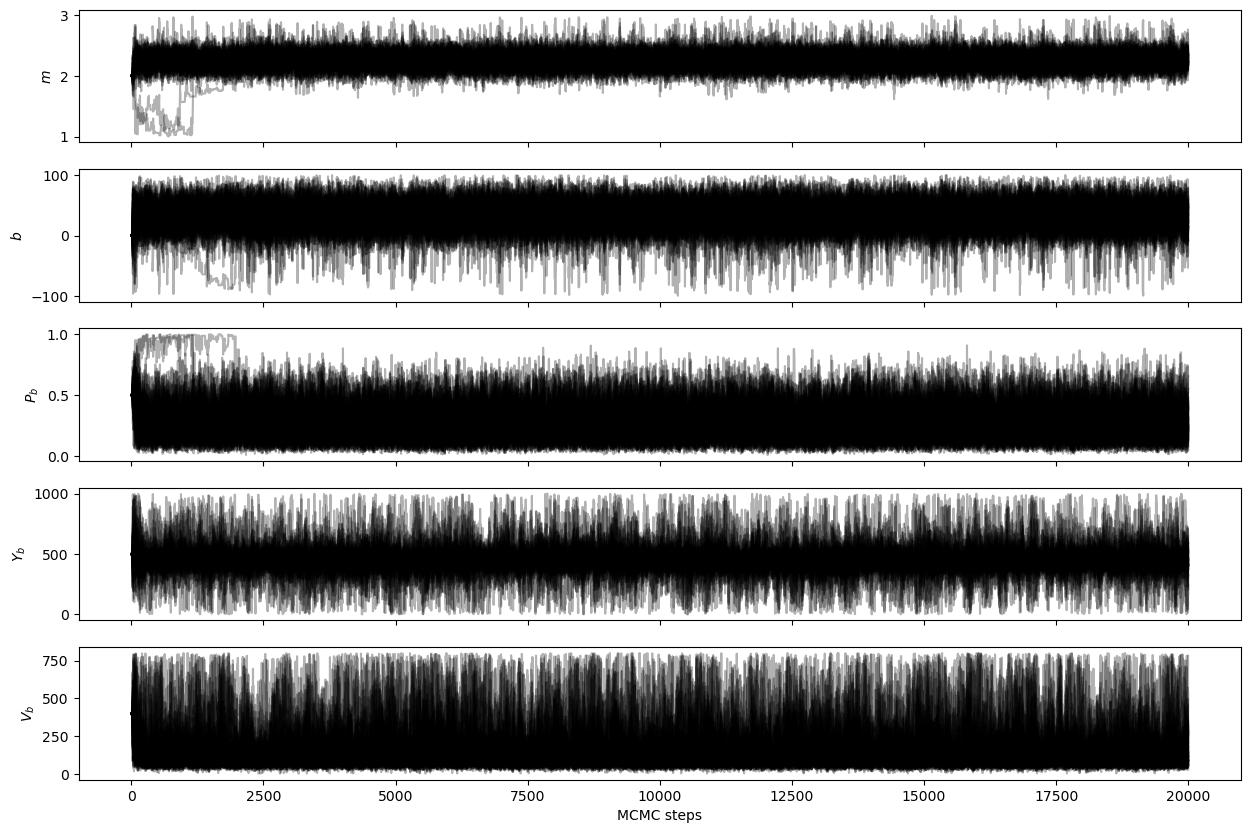

In [143]:
fig, axs = plt.subplots(len(labels), figsize=(3 * len(labels), 10), sharex=True)
samples = sampler.get_chain()

for i, (ax, label) in enumerate(zip(axs, labels)):
    ax.plot(samples[:,  :,  i], c='k', label=label, alpha=0.3)
    ax.set_ylabel(label)

axs[-1].set_xlabel('MCMC steps')
plt.show()

We plot below a corner plot of all five variables:

[ 78.95418544  65.79958657  91.49540848  79.6530497  106.59352869]


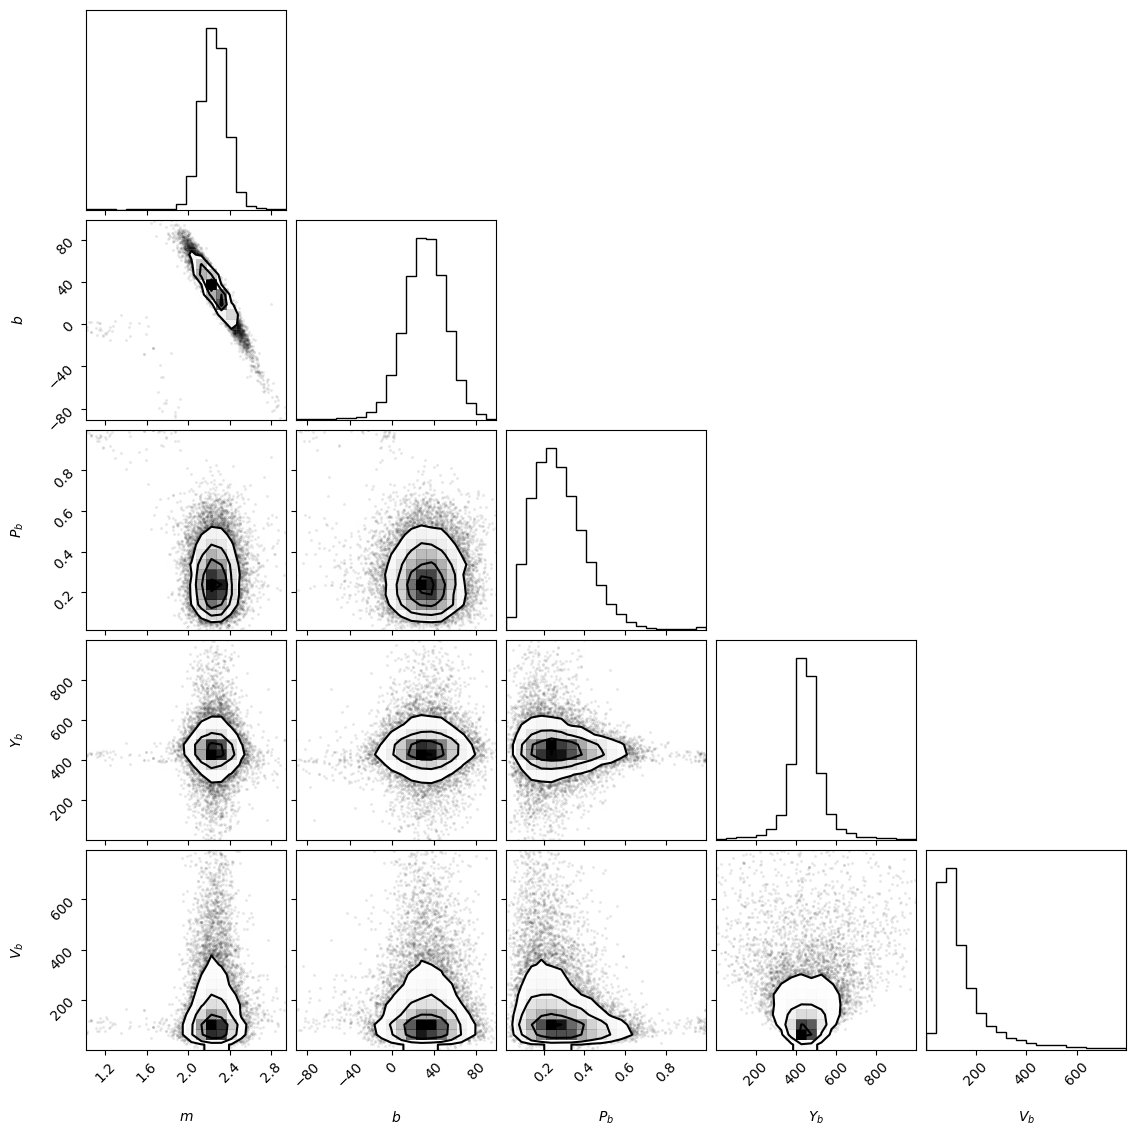

In [144]:
tau = sampler.get_autocorr_time()
print(tau)
thin = round(np.max(tau) / 2)
samples = sampler.get_chain(discard=100, thin=thin, flat=True)
fig = corner(samples, labels=labels)

Let us plot $m$ and $b$ specifically:

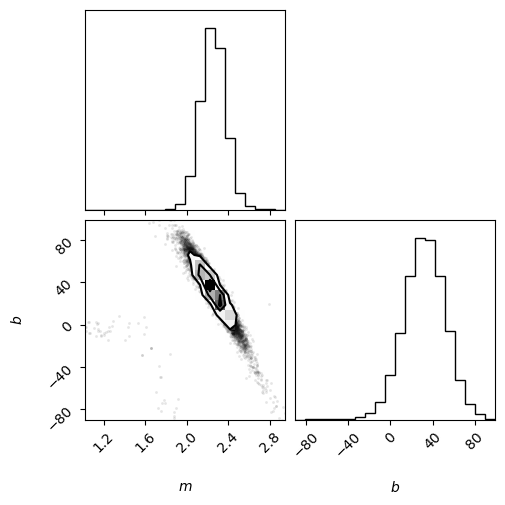

In [146]:
fig = corner(samples[:, :2], labels=labels[:2])

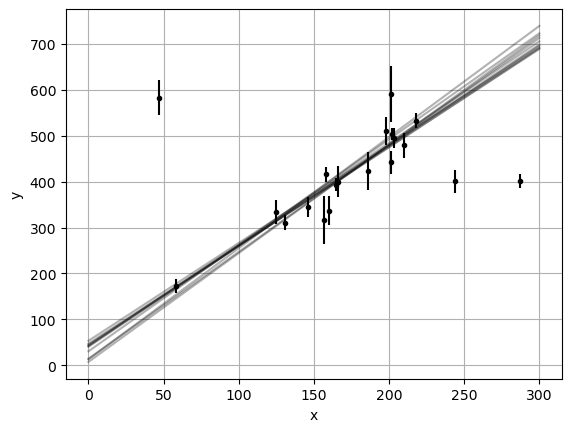

In [149]:
n_lines = 10
lines = np.random.choice(samples.shape[0], n_lines)
m_samples, b_samples = samples[lines, 0], samples[lines, 1]
for i in range(n_lines):
    plt.plot(x_fit, x_fit * m_samples[i] + b_samples[i], alpha=0.3, c='k')
plt.errorbar(x, y, yerr=sigma_y, fmt=".k")
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.show()